In [1]:
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import torch
import transformers
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
dataset = load_dataset("bavard/personachat_truecased")
persona_qualities = list(set([sent 
                      for item in dataset['train']['personality'] 
                          for sent in item]))
persona_quality_to_id = {quality: i for i, quality in enumerate(persona_qualities)}
print(f'{len(persona_qualities)} persona qualities')
clear_output()

In [3]:
train_personalities = [sent for persona in dataset['train']['personality'] 
                               for sent in persona]
test_personalities = [sent for persona in dataset['train']['personality'] 
                               for sent in persona]

Соберем все предложения из персональностей в один сет

In [4]:
personalities = set(train_personalities) | set(test_personalities)

Загрузим модель, посчитаем ембеддинги попробуем визуализировать с помощью PCA

In [5]:
model_name = 'paraphrase-MiniLM-L6-v2'
model = SentenceTransformer(model_name, device='cpu')

In [6]:
%%time
embeddings = model.encode(list(personalities))

CPU times: user 5min 49s, sys: 8.5 s, total: 5min 57s
Wall time: 8.72 s


In [9]:
import umap

In [10]:
umap = umap.UMAP(n_components=2)

In [11]:
emb_2d = umap.fit_transform(embeddings)

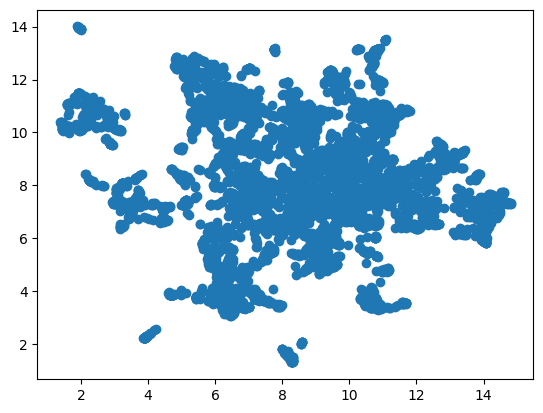

In [12]:
plt.scatter(emb_2d[:,0], emb_2d[:,1]);

Далее функция для более подробной визуализации эмбеддингов

In [13]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [14]:
draw_vectors(emb_2d[:, 0], emb_2d[:, 1],
             phrase=[sent[:50] for sent in personalities],
             radius=20,)

figure(id='p1005', ...)

выглядит не очень...

Попробуем кластеризовать эмбеддинги

In [74]:
k_means_clustering = KMeans(n_clusters=500)

In [75]:
k_means_clustering.fit(embeddings)

KMeans(n_clusters=500)

In [76]:
clusters = k_means_clustering.predict(embeddings)

In [77]:
np.array(list(personalities))[clusters == 0]

array(['My mom is a music teacher at the elementary school.',
       'Both of my parents are teachers.',
       'My mother is a teacher in the city.',
       'My mother is a retired teacher.', 'My mother is a teacher.',
       'My parents both are school teachers.',
       'My mother was a Sunday school teacher.',
       'My mother is a school teacher.', 'Both my parents were teachers.',
       'My mother was a piano teacher.', 'My wife use to be a teacher.',
       'My dad works at the mill and my mom is a teacher.',
       'My mother was a concert pianist.', 'My mother was a teacher.',
       'My mother was a school music teacher.'], dtype='<U167')

In [78]:
np.array(list(personalities))[clusters == 1]

array(["My doctor told me I've six months to live.",
       'I have been married five times.',
       'I ve been married for five years.',
       "I've been married for 6 years.", "I'm married with 5 kids.",
       'I plan to retire in 6 months.',
       'I am getting married in six months.',
       'I ve been married five times.',
       "I'm getting married in six months.",
       'I m getting married in six months.',
       "I've been married for five years.",
       "I'm married and have five children.",
       "I've been married eight years.", 'I am married with 5 kids.',
       'I have been married eight years.',
       'I have been married for 6 years.',
       'I am married and have five children.',
       'I have been married for five years.',
       'My doctor told me I have six months to live.',
       "I've been married five times."], dtype='<U167')

In [79]:
np.array(list(personalities))[clusters == 245]

array(['I ride a unicycle.', 'My car broke down last week.',
       'I once drove a car! My friend told me what to do while I drove.',
       'I lost my arm in a car accident.',
       'I recently lost both my parents to an automobile accident.',
       'I have been in 2 car crashes in my life.',
       'My back hurts chronically.',
       "I've been in 2 car crashes in my life."], dtype='<U167')

In [86]:
np.array(list(personalities))[clusters == 450]

array(['I work at the gas station as a part time job.',
       'During the week, I work as a barista.', 'I work as a waitress.',
       'I work as a barista.', 'I work as a bartender.',
       'I am a barista.', "I'm a barista."], dtype='<U167')

In [90]:
np.array(list(personalities))[clusters == 490]

array(['I do not trust anyone.', "I don't trust anyone.",
       'I don T trust anyone.', 'I don T believe any A.'], dtype='<U167')

In [89]:
np.array(list(personalities))[clusters == 499]

array(['I use to be a huge superman fan as a child.',
       'My favorite hero is superman.',
       'Superman s my favorite super hero.',
       'Superfans my favorite super hero.'], dtype='<U167')

In [91]:
np.array(list(personalities))[clusters == 29]

array(["I'm the middle child of 3 siblings.", 'I have three kids.',
       "I've three daughters.", 'I have a 3 year old.',
       'I m the middle child of 3 siblings.', 'I have three sisters.',
       "I've three children.", "I've 3 kids.", "I've 3 brothers.",
       "I've three kids.", 'I have three children.', 'I have 3 kids.',
       "I've a family of three daughters.",
       'I am the middle child of 3 siblings.', "I've 3 children.",
       'I have two children, a boy and a girl.',
       'I already have 3 children.', 'I have 3 children.',
       "I've a 3 year old.", "I've three sisters.", 'I have 3 brothers.',
       'I have three daughters.', 'I have a family of three daughters.'],
      dtype='<U167')

Выглядит очень круто, попробуем еще уменьшить количество кластеров

In [92]:
k_means_clustering = KMeans(n_clusters=200)

In [93]:
k_means_clustering.fit(embeddings)

KMeans(n_clusters=200)

In [94]:
clusters = k_means_clustering.predict(embeddings)

In [95]:
np.array(list(personalities))[clusters == 29]

array(['Its great fun.', 'I am bored of my maids.',
       "I'm bored of my maids.", 'I am funny.', 'I am a weirdo.',
       'I love to gossip.', 'I m funny.', "People say I've a cute laugh.",
       'I love to laugh.', 'I sometimes scratch my nose for fun.',
       "I'm witty.", 'Sometimes I listen to Gary human to be ironic.',
       "I'm funny.", 'I am witty.',
       'I love people with a sense of humor.', 'I like being weird.',
       'I love to tell jokes.', 'I love laughing.',
       'I often play the clown to get attention.',
       'Some jokes go too far.',
       'Sometimes I listen to Gary numan to be ironic.',
       'It s great fun.', "I'm a weirdo.", 'I tell bad jokes on purpose.',
       'I am a very funny woman.', 'People say I have a cute laugh.',
       "I'm a very funny woman.", 'I like simple jokes.'], dtype='<U167')

In [96]:
np.array(list(personalities))[clusters == 199]

array(["I'm always early.", 'I usually go to bed late.',
       "I don't like waking up early.", 'I am always late.',
       'I don T like waking up early.', "I'm always early to everything.",
       'I m always early.', "I'd rather stay up late than get up early.",
       'I take forever to get tasks done so I start early and clock out late.',
       'I would rather stay up late than get up early.',
       'I m always early to everything.',
       'I am always early to everything.', 'I am always early.',
       'I go to bed pretty late.', 'I do not like waking up early.',
       "I'm always late."], dtype='<U167')

In [97]:
np.array(list(personalities))[clusters == 21]

array(["I've never broken a bone.",
       'I could never be locked down to one partner.',
       'My motor never stops running.', "I've never had alcohol.",
       "I've never had candy in my life.", 'I have never broken a bone.',
       'I never have had alcohol in my life.',
       "I've never done drugs because I don't know where to buy them.",
       'I have never lost a fight.',
       "I've never done drugs because I do not know where to buy them.",
       'I have never had candy in my life.', "I've never lost a fight.",
       'I never sleep in.',
       "I have never done drugs because I don't know where to buy them.",
       'I have never had alcohol.',
       'I ve never done drugs because I don T know where to buy them.'],
      dtype='<U167')

In [98]:
np.array(list(personalities))[clusters == 1]

array(['I like meat.', 'I love meat.',
       'I am a vegetarian but I eat fish, especially sushi.',
       "I'm lazy and pork tastes good.",
       'I am lazy and pork tastes good.', 'I eat meat.',
       "I'm a meat eater.",
       'I try to limit how much meat I eat for health reasons.',
       'I like to eat meat.', 'I love beef.',
       'I could eat meatloaf every night and never get tired of it.',
       'I eat a lot of meat.', 'I am primarily a meat eater.',
       'I m a vegetarian but I eat fish, especially sushi.',
       "I'm a foodie.", 'I am a foodie.', "I'm a meataholic.",
       'I am a meat eater.', 'I enjoy my steaks cooked medium rare.',
       'I like to only eat fish.', 'I love to eat meat.',
       'I am a meataholic.',
       "I'm a vegetarian but I eat fish, especially sushi.",
       'I like meat too much.', 'I eat a lot of fish.',
       "I'm primarily a meat eater.", 'I eat exclusively meat.',
       'I like to eat beef.'], dtype='<U167')

In [99]:
np.array(list(personalities))[clusters == 3]

array(["I'm an environmental engineer.", 'I work at a power plant.',
       "I'm a factory worker.", 'I was a mechanic for 6 years.',
       'I think if I work hard enough I can fix the world.',
       'I wear a uniform to work.', "I'm a mechanic.",
       'I work as a contractor for a cab company.',
       'I used to work for Monsanto.', 'I work as a plumber.',
       'I work in a lab.', 'I used to work at a factory making boxes.',
       "I'm training to be a welder.", 'Welding is my career field.',
       'My wife works as a diesel mechanic.', 'I work in a warehouse.',
       'I am an engineer.', 'I work for the railroad.',
       'I am a factory worker.',
       'I work a dead end 9 to 5 job as a snakeskin oil salesman.',
       'I am an environmental engineer.', 'I work at a factory.',
       'I work as a construction worker during the summers.',
       'I am a mechanic.', 'I work in construction.',
       'I used to work for a cable company.',
       'Just this past week I got a 

Кажется что лучше не уменьшать количество кластеров, попробуем пока остановится на 500

## Результаты готовой обученной модели

Теперь попробуем загрузить уже обученную модель кластеризации и посмотреть как она работает

In [5]:
import sys
sys.path.insert(0, '../..')
from models.personality_clustering import PersonalityClustering

In [6]:
p = PersonalityClustering()
p.load('../../data/models/personality_clustering_500_paraphrase-MiniLM-L6-v2_k-means.pkl')

In [7]:
personalities_list = list(personalities)
print(*[f'# {i + 1}: {item}' for i, item in enumerate(personalities_list[:10])], sep='\n')
print('#' * 30)
prediction = p.predict_nearest_personality(personalities_list[:10])
print(*[f'# {i + 1}: {item}' for i, item in enumerate(prediction)], sep='\n')


# 1: I once met a man I still believe was a vampire.
# 2: I live with my parents and my little brother.
# 3: I like crab dipped in butter.
# 4: I am 5 7 tall.
# 5: I have a new job selling cars.
# 6: I loove zumba.
# 7: Have both daughters and sons.
# 8: I post on reddit often.
# 9: I've beard that's longer.
# 10: My mom went crazy when I was three and I've not seen her since.
##############################
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
# 1: I believe in ghosts and have seen them on several occasions.
# 2: I am 25 years old and live with my parents.
# 3: I love eating shrimp, and I like to dip them into barbecue sauce.
# 4: I am 6 foot tall.
# 5: I race cars for a living.
# 6: I think I have talen

Видно что в целом неплохо, но иногда смысл практически противоположный, при том же наборе слов

Теперь для случайных предложений

In [52]:
p.predict_nearest_personality(['I love football'])

array(['I like to play football.'], dtype='<U24')

In [54]:
p.predict_nearest_personality(['I have two children'])

array(["I've two children."], dtype='<U18')

In [56]:
p.predict_nearest_personality(['My parents are German'])

array(['My parent s immigrated from Europe before I was born.'],
      dtype='<U53')

Посмотрим как это работает с короткими односложными описаниями

In [58]:
p.predict_nearest_personality(['football'])

array(['I like to play football.'], dtype='<U24')

In [59]:
p.predict_nearest_personality(['vegan'])

array(['I am a vegan.'], dtype='<U13')

In [60]:
p.predict_nearest_personality(['musician'])

array(['I am a musician.'], dtype='<U16')

In [61]:
p.predict_nearest_personality(['celebrety'])

array(['I think I have talent for it.'], dtype='<U29')

In [63]:
p.predict_nearest_personality(['genius'])

array(["I'm very smart."], dtype='<U15')

In [65]:
p.predict_nearest_personality(['mother'])

array(['I am a mother of two.'], dtype='<U21')

In [66]:
p.predict_nearest_personality(['politician'])

array(["I'm a democrat."], dtype='<U15')

In [67]:
p.predict_nearest_personality(['bike'])

array(['I ride a bike.'], dtype='<U14')

In [68]:
p.predict_nearest_personality(['libertarian'])

array(["I'm a democrat."], dtype='<U15')

In [69]:
p.predict_nearest_personality(['communist'])

array(['My parents used to work in politics, until they discovered the goodness within themselves.'],
      dtype='<U90')

Выглядит очень неплохо, и кажется этой моделью вполне можно пользоваться для получения персональности из небольшого описания в 1-2 слова